In [3]:
###### This version iV mainly using reduced features and try linear model and rf

In [2]:
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy as sp

import xgboost as xgb
#from add_features import add_features
import sklearn.cross_validation as cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import csv

from sklearn.linear_model import Lars,Ridge, Lasso, SGDClassifier,SGDRegressor,LogisticRegression,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import scale
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


In [3]:
workingdirect='C:\wanglf2016\kaggle\Liberty_Mutual_fireloss_prediction\data'
read_all=1
num_row=10000
if read_all==1:
    train_data=pd.read_csv('../data/reduced_features/traindata623.csv',sep=',',header=0)    
#    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None)    
else:
    train_data=pd.read_csv('../data/reduced_features/traindata623.csv',sep=',',header=0,\
                           skiprows=range(1,10), nrows=num_row)
#    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None,\
#                           skiprows=range(1,10), nrows=num_row)

# test_data=pd.read_csv('../data/reduced_features/testdata623.csv',sep=',',header=0,\
#                           skiprows=range(1,10), nrows=10000)
test_data=pd.read_csv('../data/reduced_features/testdata623.csv',sep=',',header=0)

num_train=len(train_data)
num_test=len(test_data)

print('total train data={}'.format(len(train_data)))
print('total test data={}'.format(len(test_data)))

total train data=452061
total test data=450728


In [4]:
train_data.columns

Index([u'var4', u'var7', u'var8', u'var9', u'var10', u'var11', u'var13',
       u'var15', u'var17', u'weahter_trim1', u'weahter_trim48', u'pca_geo1',
       u'pca_geo2', u'pca_crime1', u'pca_crime2', u'var4_A1', u'var4_B1',
       u'var4_C1', u'var4_D1', u'var4_D2', u'var4_D3', u'var4_D4', u'var4_E1',
       u'var4_E2', u'var4_E3', u'var4_E4', u'var4_E5', u'var4_E6', u'var4_F1',
       u'var4_G1', u'var4_G2', u'var4_H1', u'var4_H2', u'var4_H3', u'var4_I1',
       u'var4_J1', u'var4_J2', u'var4_J3', u'var4_J4', u'var4_J5', u'var4_J6',
       u'var4_K1', u'var4_L1', u'var4_M1', u'var4_N1', u'var4_O1', u'var4_O2',
       u'var4_P1', u'var4_R1', u'var4_R2', u'var4_R3', u'var4_R4', u'var4_R5',
       u'var4_R6', u'var4_R7', u'var4_R8', u'var4_S1', u'var4_Z', u'var9_A',
       u'var9_B', u'var9_Z', u'target', u'label', u'logloss'],
      dtype='object')

In [5]:
labels = train_data['label']
logloss = train_data['logloss']
weights = train_data['var11']
target = train_data['target']
train_data.drop(['var11','label','target', 'logloss'], axis=1, inplace=True)

In [6]:
weight_test=test_data['var11']
test_data.drop(['var11'], axis=1, inplace=True)

In [7]:
train_data.drop(['var4', 'var9'], axis=1, inplace=True)
test_data.drop(['var4', 'var9'], axis=1, inplace=True)

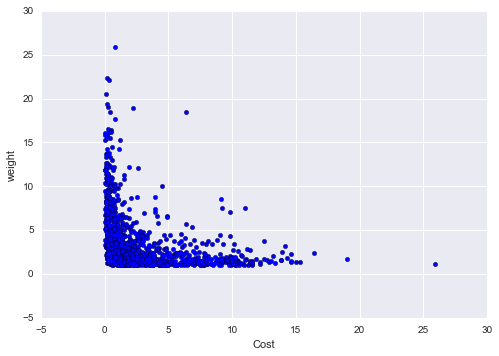

In [8]:
pos_index=[i for (i,x) in enumerate(labels) if x>0 ]
weight_pos=weights[pos_index]
sign_pos=target[pos_index]
unit_scale=max(weight_pos)/max(sign_pos)
weight_scaled=weight_pos*sign_pos
plt.scatter(sign_pos,weight_pos/unit_scale)
#plt.hist(weight_scaled/unit_scale,bins=50)
plt.xlabel('Cost')
plt.ylabel('weight')

In [9]:
features_name=train_data.columns
num_features=train_data.shape[1]
print ('number total features={}'.format(num_features))
features_name

number total features=58


Index([u'var7', u'var8', u'var10', u'var13', u'var15', u'var17',
       u'weahter_trim1', u'weahter_trim48', u'pca_geo1', u'pca_geo2',
       u'pca_crime1', u'pca_crime2', u'var4_A1', u'var4_B1', u'var4_C1',
       u'var4_D1', u'var4_D2', u'var4_D3', u'var4_D4', u'var4_E1', u'var4_E2',
       u'var4_E3', u'var4_E4', u'var4_E5', u'var4_E6', u'var4_F1', u'var4_G1',
       u'var4_G2', u'var4_H1', u'var4_H2', u'var4_H3', u'var4_I1', u'var4_J1',
       u'var4_J2', u'var4_J3', u'var4_J4', u'var4_J5', u'var4_J6', u'var4_K1',
       u'var4_L1', u'var4_M1', u'var4_N1', u'var4_O1', u'var4_O2', u'var4_P1',
       u'var4_R1', u'var4_R2', u'var4_R3', u'var4_R4', u'var4_R5', u'var4_R6',
       u'var4_R7', u'var4_R8', u'var4_S1', u'var4_Z', u'var9_A', u'var9_B',
       u'var9_Z'],
      dtype='object')

In [10]:
#num_fire=len([ytrain_data>0])
num_fire=len(pos_index)
print ('True signal percentage= {}'.format(1.0*num_fire/num_train))

True signal percentage= 0.00262796392522


In [11]:
num_miss_col=np.sum(train_data.isnull())
num_miss_row=np.sum(train_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))

number of missing col=var7              0
var8              0
var10             0
var13             0
var15             0
var17             0
weahter_trim1     0
weahter_trim48    0
pca_geo1          0
pca_geo2          0
pca_crime1        0
pca_crime2        0
var4_A1           0
var4_B1           0
var4_C1           0
var4_D1           0
var4_D2           0
var4_D3           0
var4_D4           0
var4_E1           0
var4_E2           0
var4_E3           0
var4_E4           0
var4_E5           0
var4_E6           0
var4_F1           0
var4_G1           0
var4_G2           0
var4_H1           0
var4_H2           0
var4_H3           0
var4_I1           0
var4_J1           0
var4_J2           0
var4_J3           0
var4_J4           0
var4_J5           0
var4_J6           0
var4_K1           0
var4_L1           0
var4_M1           0
var4_N1           0
var4_O1           0
var4_O2           0
var4_P1           0
var4_R1           0
var4_R2           0
var4_R3           0
var4_R4           

In [12]:
train_data.columns

Index([u'var7', u'var8', u'var10', u'var13', u'var15', u'var17',
       u'weahter_trim1', u'weahter_trim48', u'pca_geo1', u'pca_geo2',
       u'pca_crime1', u'pca_crime2', u'var4_A1', u'var4_B1', u'var4_C1',
       u'var4_D1', u'var4_D2', u'var4_D3', u'var4_D4', u'var4_E1', u'var4_E2',
       u'var4_E3', u'var4_E4', u'var4_E5', u'var4_E6', u'var4_F1', u'var4_G1',
       u'var4_G2', u'var4_H1', u'var4_H2', u'var4_H3', u'var4_I1', u'var4_J1',
       u'var4_J2', u'var4_J3', u'var4_J4', u'var4_J5', u'var4_J6', u'var4_K1',
       u'var4_L1', u'var4_M1', u'var4_N1', u'var4_O1', u'var4_O2', u'var4_P1',
       u'var4_R1', u'var4_R2', u'var4_R3', u'var4_R4', u'var4_R5', u'var4_R6',
       u'var4_R7', u'var4_R8', u'var4_S1', u'var4_Z', u'var9_A', u'var9_B',
       u'var9_Z'],
      dtype='object')

In [11]:
train_data.head(10)

,var7,var8,var10,var13,var15,var17,weahter_trim1,weahter_trim48,pca_geo1,pca_geo2,...,var4_R4,var4_R5,var4_R6,var4_R7,var4_R8,var4_S1,var4_Z,var9_A,var9_B,var9_Z
0,3,1,3.898949,0.000000,29.000000,84.337349,0,0.112556,-0.851407,0.236054,...,0,0,0,0,0,0,0,1,0,0
1,3,2,3.898949,1.268636,23.000000,100.000000,0,0.033052,-0.774846,0.057575,...,0,0,0,0,0,0,0,1,0,0
2,2,4,4.314082,2.482178,31.190926,0.000000,0,0.566352,0.012889,-0.041014,...,0,0,0,0,0,0,0,0,0,1
3,3,4,4.314082,2.054144,22.000000,100.000000,0,0.290147,0.414365,0.046461,...,0,0,0,0,0,0,0,0,0,1
4,2,4,3.898949,0.832555,21.000000,2.421308,0,1.313732,-0.264987,0.017974,...,0,0,0,0,0,0,0,1,0,0
5,4,2,3.824453,1.268636,11.000000,80.000000,0,1.173893,0.371219,0.374754,...,0,0,0,0,0,0,0,1,0,0
6,3,3,3.898949,0.832555,17.000000,86.187845,0,0.789888,0.550118,-0.234879,...,0,0,0,0,0,0,0,1,0,0
7,3,3,4.171214,1.835019,28.000000,100.000000,0,0.003998,0.312152,-0.256252,...,0,0,0,0,0,0,0,1,0,0
8,3,1,4.039930,1.268636,44.000000,64.285714,0,2.222157,0.194191,-0.054439,...,0,0,0,0,0,0,0,0,1,0
9,3,1,4.039930,1.177410,26.000000,100.000000,0,0.037004,-3.454792,-0.177641,...,0,0,0,0,0,0,0,1,0,0


###### summary: new data: remove ['var12', 'var14', 'var16', 'var1', 'var3', 'var2', 'var5', 'var6'], keep two weather
add logloss and label

In [28]:
test_data.head(10)

,var7,var8,var10,var13,var15,var17,weahter_trim1,weahter_trim48,pca_geo1,pca_geo2,...,var4_R4,var4_R5,var4_R6,var4_R7,var4_R8,var4_S1,var4_Z,var9_A,var9_B,var9_Z
0,4,2,4.171214,1.048147,38,100.000000,0,0.112556,-0.851407,0.236054,...,0,0,0,0,0,0,0,1,0,0
1,6,4,4.039930,1.700109,9,93.623766,0,0.033052,-0.774846,0.057575,...,0,0,0,0,0,0,0,1,0,0
2,7,2,3.776480,1.177410,35,98.009950,0,0.566352,0.012889,-0.041014,...,0,0,0,0,0,0,0,1,0,0
3,5,3,4.314082,2.227744,45,62.598345,0,0.290147,0.414365,0.046461,...,0,0,0,0,0,0,0,0,0,1
4,2,2,3.898949,1.177410,66,0.000000,0,1.313732,-0.264987,0.017974,...,0,0,0,0,0,0,0,1,0,0
5,3,2,4.039930,0.000000,31,70.579268,0,1.173893,0.371219,0.374754,...,0,0,0,0,0,0,1,1,0,0
6,4,3,4.171214,0.000000,70,100.000000,0,0.789888,0.550118,-0.234879,...,0,0,0,0,0,0,0,0,1,0
7,3,1,4.171214,1.394959,43,100.000000,0,0.003998,0.312152,-0.256252,...,0,0,0,0,0,0,0,1,0,0
8,7,4,4.171214,1.394959,27,34.210526,0,2.222157,0.194191,-0.054439,...,0,0,0,0,0,0,0,0,0,1
9,3,3,4.509069,0.832555,31,43.466731,0,0.037004,-3.454792,-0.177641,...,0,0,0,0,0,0,0,0,0,1


In [98]:
nr_plot1=1
nr_plot2=10000
data_plot=train_data.iloc[nr_plot1:nr_plot2,13:16]
data_plot['label']=labels[nr_plot1:nr_plot2]

ValueError: zero-size array to reduction operation minimum which has no identity

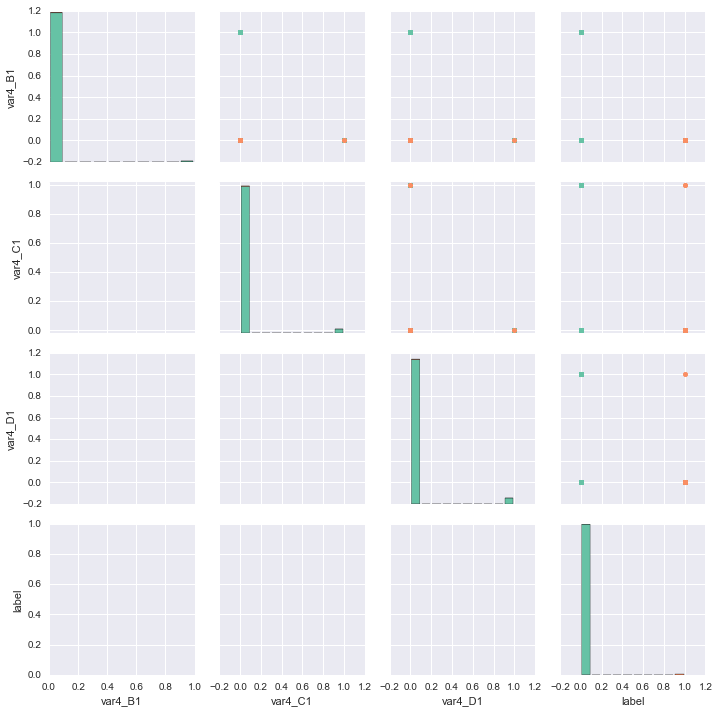

In [99]:
g = sns.PairGrid(data_plot, hue = 'label', palette='Set2',\
hue_kws={'cmap':['Greens','Reds']})
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.add_legend()

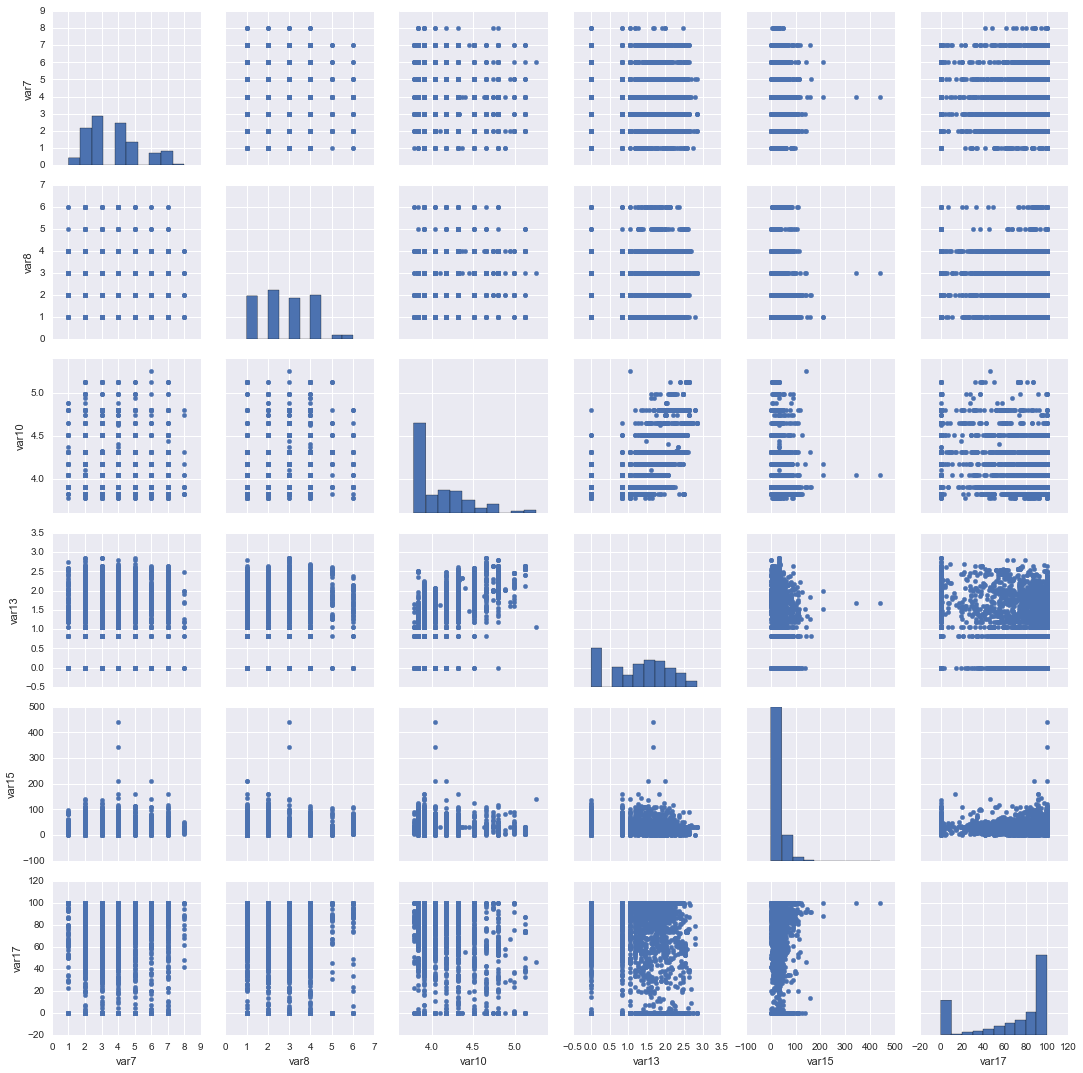

In [100]:
g = sns.PairGrid(train_data.iloc[0:3000,0:6])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

C:\Users\wanglf\Anaconda2\lib\site-packages\seaborn\linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


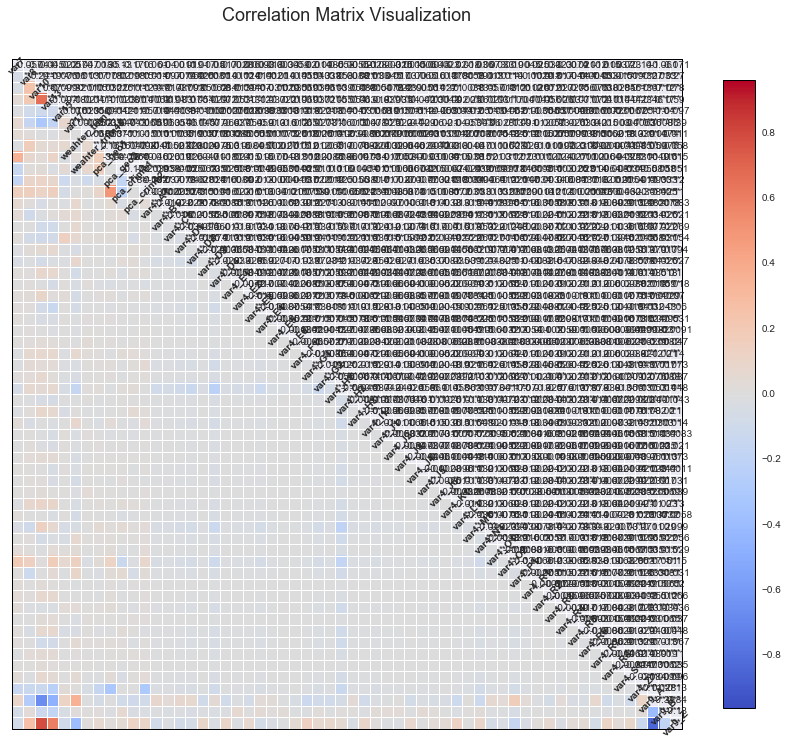

In [130]:
fig = plt.figure(figsize=(15,15))
sns.corrplot(train_data)
plt.title("Correlation Matrix Visualization",fontsize=18)
fig.set_dpi(1240)
fig.savefig('corrplot.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
fig.set_dpi(1240)
fig.savefig('corrplot.png', transparent=True, bbox_inches='tight', pad_inches=0)

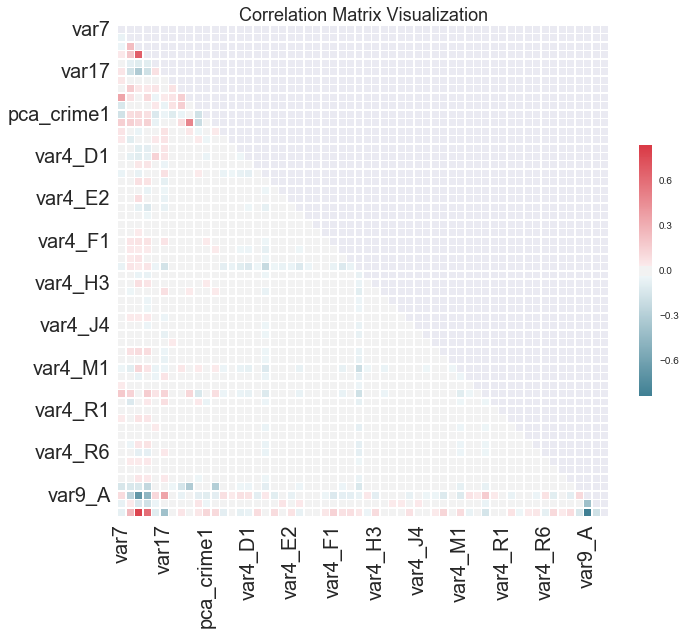

In [143]:
#xtrain_data.corr()
fig = plt.figure(figsize=(12,12))
corr= train_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=2
# sns.graphics.plot_corr(corr_matrix, xnames=xtrain_data.names)
# plt.show()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Correlation Matrix Visualization",fontsize=18)
fig.set_dpi(1240)
fig.savefig('xgbcorrplot2.png', transparent=True, bbox_inches='tight', pad_inches=0)

# functions

In [13]:
import sklearn.metrics
import time
def evaluate_model(clf):
    """Scores a model using log loss with the created train and test sets."""
    start = time.time()
    clf.fit(X_train, y_train)
    print ("Train score:", sklearn.metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print ("Test score:", sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    print ("Total time:", time.time() - start)

In [14]:
from __future__ import division
import pandas as pd
import numpy as np

def weighted_gini(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort_values('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    gini = sum(df.lorentz[1:].values * (df.random[:-1])) - sum(df.lorentz[:-1].values * (df.random[1:]))
    return gini
def normalized_weighted_gini(act,pred,weight):
    return weighted_gini(act,pred,weight) / weighted_gini(act,act,weight)

def weighted_gini_line(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort_values('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    df["gini"] = (df.lorentz[1:].values * (df.random[:-1])) - (df.lorentz[:-1].values * (df.random[1:]))
    return (df)


In [15]:
# function gini = weighted_gini(act,pred,weight)

# [~, I] = sort(pred);
# weight = weight(I);
# act = act(I);

# drandom = cumsum(weight);
# drandom = drandom / drandom(end);
# lorentz = cumsum(act.*weight);
# lorentz = lorentz / lorentz(end);

# gini = sum(lorentz(2:end).*drandom(1:end-1)) - sum(lorentz(1:end-1).*drandom(2:end));


# function f = normalized_weighted_gini(act,pred,weight)
# f = weighted_gini(act,pred,weight) / weighted_gini(act,act,weight);

In [16]:
def compare_listcomp(x, y):
    return [1 for i, j in zip(x, y) if i == j]

import pylab as pl
import sklearn.metrics as skm
import math
def summary_model(clf):
    test_pred=clf.predict(X_test)
    train_pred=clf.predict(X_train)
    accuracy_test=1.0*sum(compare_listcomp(test_pred,y_test))/len(y_test)
    accuracy_train=1.0*sum(compare_listcomp(train_pred,y_train))/len(y_train)
    print("prediction accuaracy on the trainning data= %f" %(accuracy_train))
    print("prediction accuaracy on the test      data= %f" %(accuracy_test))
    print("mean accuracy score for validation set = %f" %(clf.score(X_train, y_train)))
    print("mean accuracy score for test set = %f" %(clf.score(X_test, y_test)))
    test_cm = skm.confusion_matrix(y_test,test_pred)
    pl.matshow(test_cm)
    pl.title('Confusion matrix for test data')
    pl.colorbar()
    pl.show()
    gini_score=normalized_weighted_gini(y_test,test_pred,weight_sub_test)
    print('gini score of whole training data={}'.format(gini_score))

#     print('confusing table,\n')
#     print(test_cm)
#     test_truth=y_test
#     # Accuracy
#     print("Accuracy = %f" %(clf.accuracy_score(test_truth,test_pred)))
#     # Precision
#     print("Precision = %f" %(clf.precision_score(test_truth,test_pred)))
#     # Recall
#     print("Recall = %f" %(clf.recall_score(test_truth,test_pred)))
#     # F1 Score
#     print("F1 score = %f" %(clf.f1_score(test_truth,test_pred)))

In [17]:
def weighted_lorentz_line(act,pred,weight,pref):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    if perf==0:
        df = df.sort_values('pred',ascending=True)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    df["gini"] = (df.lorentz[1:].values * (df.random[:-1])) - (df.lorentz[:-1].values * (df.random[1:]))
    return (df)

In [18]:
def get_accuracy(prediction, solution):
    '''
    Returns the true and false positive rates.
    This assumes that:
        label 's' corresponds to 1 (int)
        label 'b' corresponds to 0 (int)
    '''
    assert prediction.size == solution.size

    # Compute sum of weights for true and false positives
    accuracy=1.0*sum([1 for i, j in zip(prediction, solution) if i == j])/len(solution)
    T11=sum([1 for i, j in zip(prediction, solution) if i==1 and j==1])  #TT
    T12=sum([1 for i, j in zip(prediction, solution) if i==0 and j==1])  #Nn
    T21=sum([1 for i, j in zip(prediction, solution) if i==1 and j==0])  #FP
    T22=sum([1 for i, j in zip(prediction, solution) if i==0 and j==0])   #TF
	# print('True positive rate= %f'%(1.0*T11/(T21+T11)))
	# print('Flase positive rate= %f'%(1.0*T12/(T21+T11)))
	# print('True Negative rate= %f'%(1.0*T22/(T12+T22)))
	# print('Flase Negative rate= %f'%(1.0*T12/(T12+T22)))
	# print('Accuracy = %f'%(accuracy_train))
    precision=1.0*T11/(T21+T11)
    FP=1.0*T21/(T21+T11)
    TN=1.0*T22/(T12+T22)
    FN=1.0*T12/(T12+T22)
    return (accuracy,precision,FP,TN,FN,T11,T12,T21,T22)

In [19]:
def estimate_performance_xgboost(X,labels,weights, param, num_round, folds):
    '''
    Cross validation for XGBoost performance
    '''
    # Load training data
#     f=open("summary_bst_scan.txt","a")
#     X, labels, weights = get_training_data(training_file)
    f=open("summary_bst_scan.txt","a")
    start = np.random.random_integers(1000) #time.time()
    # Cross validate
    kf = cv.KFold(labels.size, n_folds=folds, random_state=start)
    npoints  =10
    # Dictionary to store all the AMSs
    ams_best_idall_AMS = {}
    all_GINI = []
    summay_table=[]
#     for curr in range(npoints):
#         all_GINI[curr] = []
    # These are the cutoffs used for the XGBoost predictions
    cutoffs  = sp.linspace(0.0018, 0.0025, npoints)
    for train_indices, test_indices in kf:
        X_train, X_test = X.loc[train_indices], X.loc[test_indices]
        y_train, y_test = labels[train_indices], labels[test_indices]
        w_train, w_test = weights[train_indices], weights[test_indices]

        # Rescale weights so that their sum is the same as for the entire training set
        w_train *= (sum(weights) / sum(w_train))
        w_test  *= (sum(weights) / sum(w_test))

#         sum_wpos = sum(w_train[y_train == 1])
#         sum_wneg = sum(w_train[y_train == 0])
        sum_wpos = sum( weights[i] for i in range(len(y_train)) if y_train[i] > 0.0  )
        sum_wneg = sum( weights[i] for i in range(len(y_train)) if y_train[i] == 0.0  )    
        if (sum_wneg>  sum_wpos*100000):
            sum_wpos=1000*sum_wneg
        # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#        xgmat = xgb.DMatrix(X_train, label=y_train, missing=-999.0, weight=w_train)
        xgmat = xgb.DMatrix(X_train, label=y_train, weight=w_train)

        # scale weight of positive examples
        param['scale_pos_weight'] = sum_wneg / sum_wpos
        # you can directly throw param in, though we want to watch multiple metrics here
        plst = param.items()#+[('eval_metric', 'ams@0.15')]

        watchlist = []#[(xgmat, 'train')]
        bst = xgb.train(plst, xgmat, num_round, watchlist)

        # Construct matrix for test set
#        xgmat_test = xgb.DMatrix(X_test, missing=-999.0)
        xgmat_test = xgb.DMatrix(X_test)
        y_out = bst.predict(xgmat_test)
        num=y_test.shape[0]
        y_test=np.reshape(y_test,num)
#          print((y_test).shape)
        gini_score=normalized_weighted_gini(y_test,y_out,w_test)
        print('gini_score={}'.format(gini_score))
        f.write('gini_score={}'.format(gini_score))
        f.write('\n')
        all_GINI.append(gini_score)
###
        res  = [(i, y_out[i]) for i in xrange(len(y_out))]
        rorder = {}
        for k, v in sorted(res, key = lambda x:-x[1]):
            rorder[k] = len(rorder) + 1
        # Explore changing threshold_ratio and compute AMS
        best_prec = -1.
        k_best=0
        for curr, threshold_ratio in enumerate(cutoffs):
            y_pred = sp.zeros(len(y_out))
            ntop = int(threshold_ratio * len(rorder))
            for k, v in res:
                if rorder[k] <= ntop:
                    y_pred[k] = 1
            accu,precision,FP,TN,FN,T11,T12,T21,T22=get_accuracy(y_pred, y_test)
            summay_table.append([accu,precision,FP,TN,FN,T11,T12,T21,T22])
        
    print ("------------------------------------------------------")
    print ("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write('\n')
    summay_table_mean=[]
    n_para=9
    for j in range(npoints):
        idx_j=[j+npoints*i for i in range(folds)]
        avg=[]
        for k in range(n_para):
            avg_temp=np.mean([summay_table[i][k] for i in idx_j])
            avg.append(avg_temp)
        summay_table_mean.append(avg)    
#    print summay_table_mean
    for curr, cut in enumerate(cutoffs):
        print ("Thresh = %.4f" % (cut))
        print ("Accuracy = %.4f: Precision = %.4f, FP = %.4f" % \
            (summay_table_mean[curr][0], summay_table_mean[curr][1],\
             summay_table_mean[curr][2]))
        f.write('\n')
        f.write("Thresh = %.4f"%(cut))
        f.write('\n')
        f.write("Accuracy = %.4f: Precision = %.4f, FP = %.4f" % \
            (summay_table_mean[curr][0], summay_table_mean[curr][1],\
             summay_table_mean[curr][2]))
        f.write('\n')
        f.write("Confusing matrix")
        f.write('\n')
        f.write("TP=%.0f  FN=%.0f" %(summay_table_mean[curr][5], \
                                     summay_table_mean[curr][6]))
        f.write('\n')
        f.write("FP=%.0f  TN=%.0f" %(summay_table_mean[curr][7],\
                                     summay_table_mean[curr][8]))
        f.write('\n')
    
    f.close()

## END of Functions

# Train

In [20]:
tar_max=max(target)
tar_min=min(target)
target_nm=(target-tar_min)/(tar_max-tar_min)
target_nm=np.array(target_nm)

In [21]:
import sklearn
import sklearn.cross_validation
from sklearn.linear_model import LogisticRegression

np.random.seed(1337)
## Using target output
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(train_data,target)
#Using logloss
#X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(train_data,logloss)
## Using normalized
#X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(train_data,target_nm)
#using labels
#X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(train_data,labels)

In [22]:
ixx=list(X_train.index)
weight_sub_train=weights[ixx]
y_log_train=logloss[ixx]
y_label_train=labels[ixx]

ixx=list(X_test.index)
weight_sub_test=weights[ixx]
y_log_test=logloss[ixx]
y_label_test=labels[ixx]

### XGB Save model and predicted to file for submission ONLY

##### solution Frank

In [23]:
    sum_wpos = sum( weights[i] for i in range(len(target)) if target[i] > 0.0  )
    sum_wneg = sum( weights[i] for i in range(len(target)) if target[i] == 0.0  ) 
    if (sum_wneg>  sum_wpos*100000):
        sum_wpos=1000*sum_wneg

In [104]:
    param = {}
    param['silent'] = 1
    param['nthread'] = 1
    param['eval_metric'] = 'auc' #'rmse'
    param['objective'] ='binary:logistic'  #binary:logitraw'  
    param['bst:max_depth'] = 2
    param['min_child_weight']=1
    param['gamma']=0
    param['subsample']=1    # = c(0.5, 0.75, 1),
    param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
    param['learning_rate']=0.2
    num_round=42
    param['scale_pos_weight'] = sum_wneg / sum_wpos
    plst = param.items()#+[('eval_metric', 'ams@0.15')]   

###### Solution Ruonan

In [47]:
params2 = {'objective': 'count:poisson',
              'eta': 0.05,
              'subsample': 0.7,
              'max_depth': 6,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 5,
              'silent': 1
              }
folds = 5 
num_round = 24
#xgb2 = estimate_performance_xgboost(train_data, logloss, weights, params2, num_round, folds)

In [145]:
loglossnew=log(target+1)

In [146]:
min(loglossnew)

0.0

In [48]:
    xgmat = xgb.DMatrix(train_data, label=target, weight=weights)
    watchlist =[(xgmat, 'train')]
    
#    bst_best_model= xgb.train(plst, xgmat, num_round, watchlist)
    bst_best_model= xgb.train(params2, xgmat, num_round, watchlist)
    print('model fit done')
    # save out model
    bst_best_model.save_model('best.model')
    xgmat_test = xgb.DMatrix(test_data)
    pred = bst_best_model.predict(xgmat_test)
## new dataframe fro submission
    data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
    data_test_sub.to_csv('submissionruonan_log_05_24.csv',index=False)
##gini score of whole training data=0.555176109535

[0]	train-poisson-nloglik:0.498368
[1]	train-poisson-nloglik:0.48671
[2]	train-poisson-nloglik:0.475343
[3]	train-poisson-nloglik:0.464251
[4]	train-poisson-nloglik:0.453431
[5]	train-poisson-nloglik:0.442891
[6]	train-poisson-nloglik:0.432606
[7]	train-poisson-nloglik:0.422574
[8]	train-poisson-nloglik:0.412786
[9]	train-poisson-nloglik:0.403261
[10]	train-poisson-nloglik:0.393965
[11]	train-poisson-nloglik:0.38491
[12]	train-poisson-nloglik:0.376066
[13]	train-poisson-nloglik:0.367446
[14]	train-poisson-nloglik:0.359039
[15]	train-poisson-nloglik:0.350859
[16]	train-poisson-nloglik:0.342856
[17]	train-poisson-nloglik:0.335065
[18]	train-poisson-nloglik:0.327474
[19]	train-poisson-nloglik:0.320063
[20]	train-poisson-nloglik:0.312853
[21]	train-poisson-nloglik:0.305806
[22]	train-poisson-nloglik:0.298931
[23]	train-poisson-nloglik:0.292232
model fit done


In [ ]:
eta=0.1, nrun=10, gini score of whole training data=0.555176109535; private=2.677
eta=0.05, nrun=22, gini score of whole training data=0.607475450294; private=2.97
eta=0.05, nrun=24,gini score of whole training data=0.614783268693, private=3.03
eta=0.05, nrun=24,chld=3, gini score of whole training data=0.614783268693, private=3.03
eta=0.05, nrun=26,gini score of whole training data=0.614921237049, private=2.9591
eta=0.01, nrun=120, gini score of whole training data=0.688115881445, private=2.88

##### feather importance

gini score of whole training data=0.614783268693


(array([  2.88629000e+05,   1.51355000e+05,   9.53400000e+03,
          1.16100000e+03,   4.11000000e+02,   2.10000000e+02,
          2.10000000e+02,   2.72000000e+02,   9.60000000e+01,
          3.70000000e+01,   2.30000000e+01,   2.00000000e+01,
          6.00000000e+00,   2.40000000e+01,   1.80000000e+01,
          4.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          7.00000000e+00,   6.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

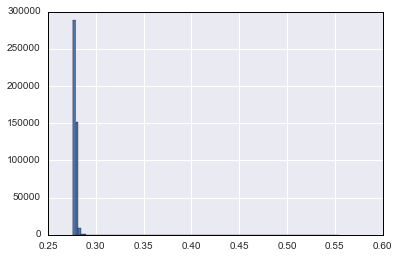

In [49]:
y_out=bst_best_model.predict(xgmat)
# num=ytrain.shape[0]
# ytrain=np.reshape(ytrain,num)
# y_out=np.reshape(y_out,num)
gini_score=normalized_weighted_gini(target,y_out,weights)
print('gini score of whole training data={}'.format(gini_score))

#plt.hist(pred,bins=50)
plt.hist(y_out,bins=100)

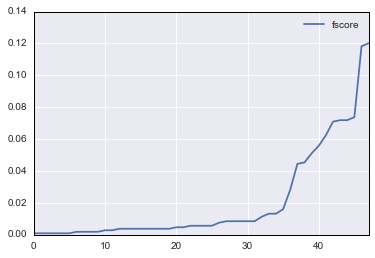

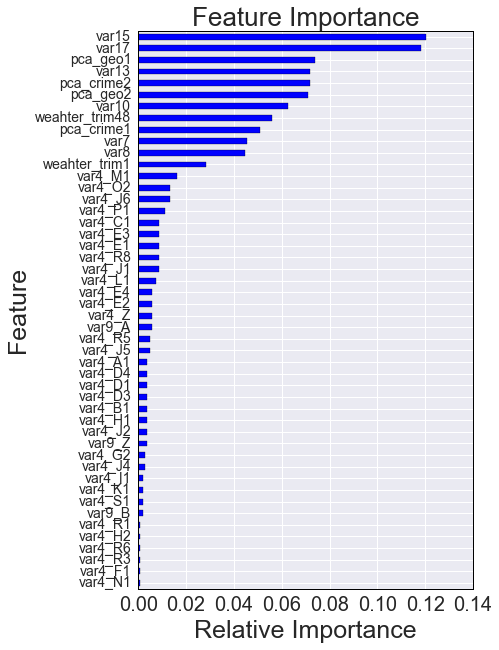

In [50]:
import operator
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

features = list(train_data.columns)
ceate_feature_map(features)
importance =bst_best_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

fig = plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('Feature Importance',fontsize=26)
plt.xlabel('Relative Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)

fig.set_size_inches(10,14) 
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.gcf().savefig('feature_importance_xgb_possion.png')



In [180]:
df_importance = df.sort_values('fscore',ascending=False)
df_importance.to_csv('gbx_fscore.csv')
df_importance.head(30)

,feature,fscore
99,var13,0.095631
98,var17,0.063067
97,var15,0.045342
96,var10,0.042869
95,var12,0.038747
94,weahter_trim33,0.025556
93,weahter_trim14,0.023083
92,weahter_trim13,0.023083
91,weahter_trim20,0.021434
90,var8,0.019786


###### Plot AUC plot

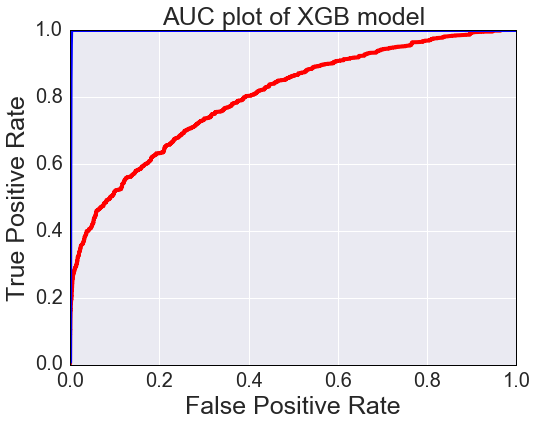

In [54]:
fig = plt.figure()
unit_weight=[1 for x in weights]
#sample_
lorentz0=weighted_gini_line(target,y_out,unit_weight)
lorentzp=weighted_gini_line(target,target,unit_weight)
plt.plot(lorentz0.random,lorentz0.lorentz,linewidth=4,color='red')
plt.plot(lorentzp.random,lorentzp.lorentz,linewidth=4,color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(8,6) 
plt.xlim([0,1])
plt.xlabel('False Positive Rate',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=25)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
plt.title('AUC plot of XGB model',fontsize=25)
fig.set_dpi(1240)
fig.savefig('AUC.png', transparent=True, bbox_inches='tight', pad_inches=0)


###### plot GINI plot

Populating the interactive namespace from numpy and matplotlib


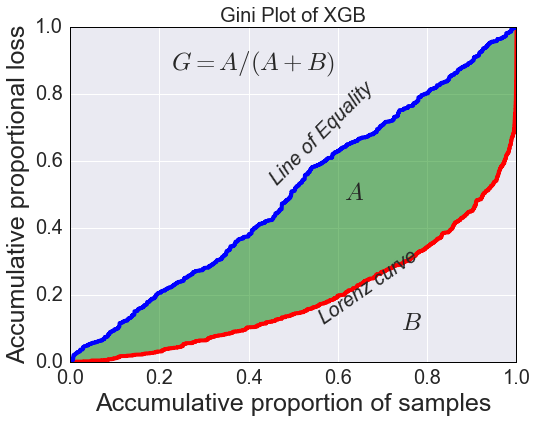

In [57]:
%pylab inline
fig = plt.figure()
unit_weight=[1 for x in weights]
perf=0
lorentz0=weighted_lorentz_line(target,y_out,weights,perf)
perf=1
lorentzp=weighted_lorentz_line(target,target,weights,perf)
plt.plot(lorentz0.random,lorentz0.lorentz,linewidth=4,color='red')
plt.plot(lorentzp.random,lorentzp.lorentz,linewidth=4,color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(8,6) 
plt.xlabel('Accumulative proportion of samples',fontsize=25)
plt.ylabel('Accumulative proportional loss',fontsize=25)
plt.xlim([0,1])
xx=np.concatenate([lorentz0.random, lorentzp.random[::-1]])
yy=np.concatenate([lorentz0.lorentz,lorentzp.lorentz[::-1]])
plt.fill(xx, yy, color='green', alpha = 0.5)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
plt.axis('on')
fig.text(0.3, 0.8, r'$G=A/(A+B)$', fontsize=25)
fig.text(0.6, 0.5, r'$A$', fontsize=25)
fig.text(0.7, 0.2, r'$B$', fontsize=25)
plt.text(0.55,0.3,'Lorenz curve', style='italic',fontsize=20,rotation=35)
plt.text(0.44,0.8,'Line of Equality', style='italic',fontsize=20,rotation=45)
plt.title('Gini Plot of XGB',fontsize=20)
fig.set_dpi(1240)
fig.savefig('GINI_xgb.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [50]:
#from sklearn import plot_importance, plot_tree, to_graphviz
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image  
xgb.plot_tree(bst_best_model,10)
xgb.to_graphvi(bst_best_model,10)

NameError: name 'bst_best_model' is not defined

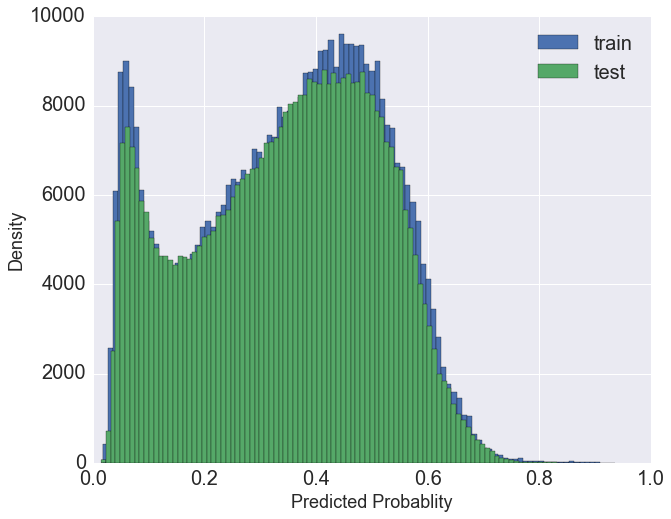

In [86]:

fig = plt.figure()
plt.hist(y_out,bins=100,label='train')
plt.hist(pred,bins=100,label='test')
plt.xlabel('Predicted Probablity',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(10,8) 
fig.set_dpi(1240)
fig.savefig('predlog.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [58]:
threshold=0.60
pred[pred>threshold]=1
pred[pred<threshold]=0    
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submission4.csv',index=False)
data_test_sub.shape

(450728, 2)

(452061, 124)
(1000, 118)
0.4


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.   ,  0.024,  0.048,  0.072,  0.096,  0.12 ,  0.144,  0.168,
         0.192,  0.216,  0.24 ,  0.264,  0.288,  0.312,  0.336,  0.36 ,
         0.384,  0.408,  0.432,  0.456,  0.48 ,  0.504,  0.528,  0.552,
         0.576,  0.6  ,  0.624,  0.648,  0.672,  0.696,  0.72 ,  0.744,
         0.768,  0.792,  0.816,  0.84 ,  0.864,  0.888,  0.912,  0.936,
         0.96 ,  0.984,  1.008,  1.032,  1.056,  1.08 ,  1.104,  1.128,
         1.152,  1.176,  1.2  ]),
 <a list of 50 Patch objects>)

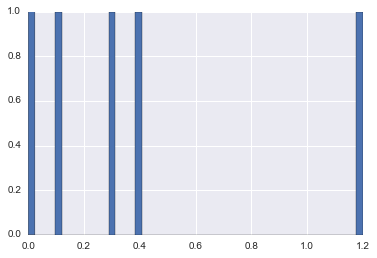

In [29]:
print xtrain_data.shape
print test_data.shape
print sum(pred)/len(pred)
plt.hist(pred,bins=50)
#True signal percentage= 0.00262796392522

In [47]:
y_train.dtype

dtype('float64')

## LogisticRegression

In [278]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
#evaluate_model(logit)
logit.fit(X_train,y_train)
#summary_model(logit)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [350]:
y_out = logit.predict_proba(X_test)[:,1]
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
gini_score

0.27073116759588217

In [351]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('scale', MinMaxScaler()), ('classifier', LogisticRegression())])
#evaluate_model(pipe)
y_out = logit.predict_proba(X_test)[:,1]
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
gini_score

0.27073116759588217

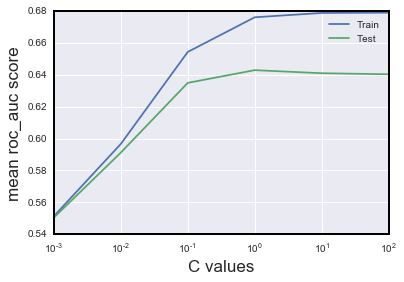

In [251]:
# evaluate for varying values of C. Plot training curves
import sklearn.learning_curve
import matplotlib.pyplot as plt
C_values =[1e-3,1e-2,1e-1,1,10,100] # fill in values
#C_values =[0.1,0.4,1, 10, 20] # fill in values

train_scores, test_scores = sklearn.learning_curve.validation_curve(
     pipe, X_train, y_train, 'classifier__C', C_values, scoring='roc_auc')
plt.semilogx(C_values,np.mean(train_scores, axis=1), label='Train')
plt.semilogx(C_values,np.mean(test_scores, axis=1), label='Test')
plt.xlabel('C values',fontsize=17)
plt.ylabel('mean roc_auc score',fontsize=17)
plt.legend(['Train','Test'])
plt.gcf().savefig('C_scan_logistic.png')

###### output best score

In [369]:
Logit_best = Pipeline([('scale', MinMaxScaler()), ('classifier', LogisticRegression())])
#Logit_best.set_params(classifier__C=0.1)
Logit_best.set_params(classifier__C=0.5)
Logit_best.fit(X_train,y_label_train)
y_out = Logit_best.predict_proba(X_test)[:,1]
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print ('gini score on test data {}'.format(gini_score))

## whole train data
Logit_best.fit(train_data,labels)
# output prediction on test data
pred = Logit_best.predict_proba(test_data)[:,1]
## new dataframe for submission
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submis_logit_cf05.csv',index=False)

y_out = Logit_best.predict_proba(train_data)[:,1]
gini_score=normalized_weighted_gini(labels,y_out,weights)
print ('gini score on whole train data {}'.format(gini_score))


gini score on test data 0.274799084823
gini score on whole train data 0.301711600719



# Linear regression

In [ ]:
# fig = plt.figure(figsize=(10,6))
# sns.boxplot(y=y_bos, x=X_bos.RAD)

###### using default parameters

In [24]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train,y_train)
y_out = ols.predict(X_test)
ols.intercept_

205569154.27496278

In [25]:
num=y_test.shape[0]
y_test=np.reshape(y_test,num)
y_out=np.reshape(y_out,num)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print('gini score={}'.format(gini_score))
#summary_model(ols)
#gini score=0.326252923238

gini score=0.353124554057


In [30]:
ols.residues_

C:\Users\wanglf\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


array([], dtype=float64)

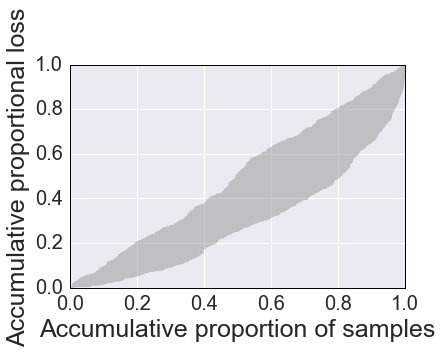

In [64]:
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(10,8) 
plt.xlabel('Accumulative proportion of samples',fontsize=25)
plt.ylabel('Accumulative proportional loss',fontsize=25)
plt.xlim([0,1])
xx=np.concatenate([lorentzp.random, lorentzp.random[::-1]])
yy=np.concatenate([lorentz0.lorentz,lorentzp.lorentz[::-1]])
plt.fill(xx, yy, color='grey', alpha = 0.4)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
plt.axis('on')
fig.set_dpi(1240)
fig.savefig('GINI_xgb_poisson.png', transparent=True, bbox_inches='tight', pad_inches=0)


##### ElasticNet scan, conlusion: penality ~0, which means defulat is best!!!

In [31]:
alphas_elastic = 1.0*np.logspace(-7, -5, 100)
#alphas_elastic = np.arange(1,10)
#alphas_elastic=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
coef_elastic = []
gini_score_elastic=[]
for i in alphas_elastic:
    elastic = linear_model.ElasticNet(l1_ratio =0.5,normalize=True)
    elastic.set_params(alpha = i)
    elastic.fit(X_train,y_train)
    coef_elastic.append(elastic.coef_)
    y_out = elastic.predict(X_test)
    gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
    gini_score_elastic.append(gini_score)
print ('scan done!')

scan done!


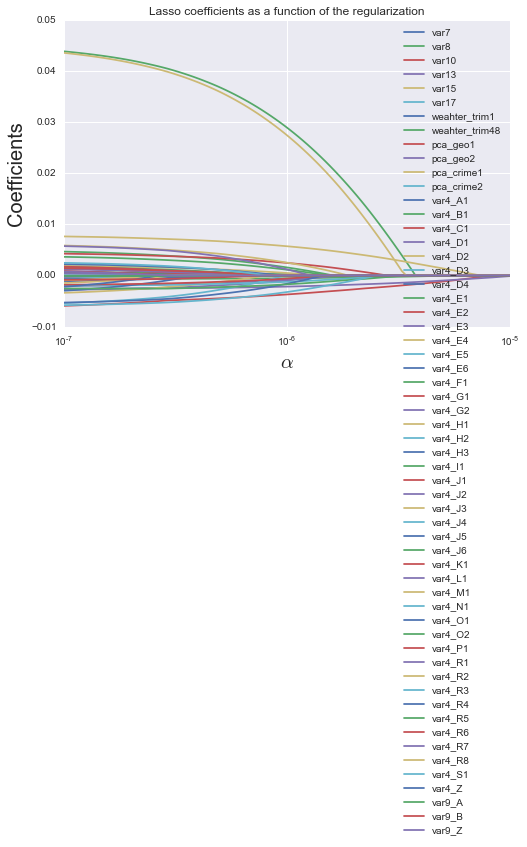

In [32]:
df_coef = pd.DataFrame(coef_elastic, index =alphas_elastic,
                       columns= train_data.columns)
# sorted_idx = np.argsort(coef_elastic)[30:num]  ##increase order
# df_coef_cut=
fig = plt.figure(figsize=(10,10))
df_coef.plot(logx = True, title = 'Lasso coefficients as a function of the regularization')
#df_coef.plot(title = 'Lasso coefficients as a function of the regularization')
fig.set_size_inches(10,8) 
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel('Coefficients',fontsize=20)
fig.set_dpi(1240)
fig.savefig('Elastic_cof_target2.png', transparent=True, bbox_inches='tight', pad_inches=0)

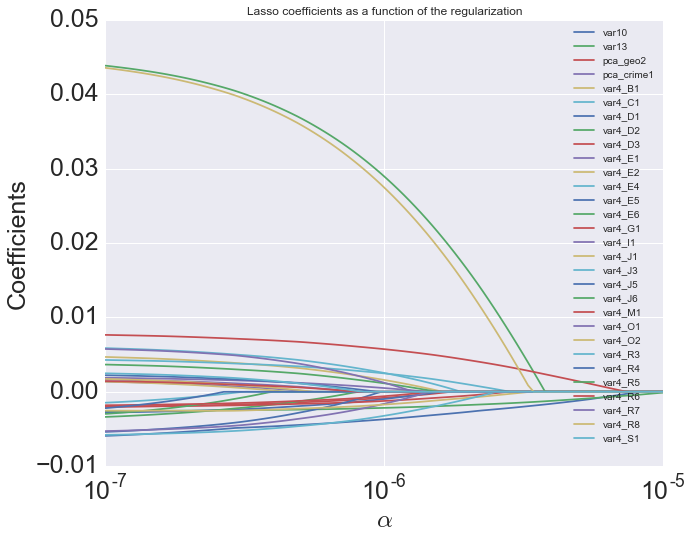

In [33]:
num2plot=30
cof0=abs(df_coef.iloc[0,:])
cof0=cof0.sort_values(ascending=False)
predname2plot=cof0.index[0:num2plot]
fea_name=df_coef.columns
features_name
df_coefcut=1.0*df_coef
for fea in fea_name:
    if fea not in predname2plot:
        df_coefcut.drop(fea,axis=1,inplace=True)
fig = plt.figure(figsize=(6,4))
df_coefcut.plot(logx = True,figsize=(10,8),fontsize=25, title = 'Lasso coefficients as a function of the regularization')
#df_coef.plot(title = 'Lasso coefficients as a function of the regularization')
fig.set_size_inches(6,4) 
plt.xlabel(r'$\alpha$',fontsize=25)
plt.ylabel('Coefficients',fontsize=25)
fig.set_dpi(1240)
fig.savefig('Elastic_cof_targetcut.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [70]:
cof0.index[0:10]
#df_coefcut.head(2)

Index([u'var4_J6', u'var4_R8', u'var4_M1', u'var10', u'var4_E4', u'var4_R3',
       u'var4_R7', u'var4_E5', u'var4_O1', u'var4_B1'],
      dtype='object')

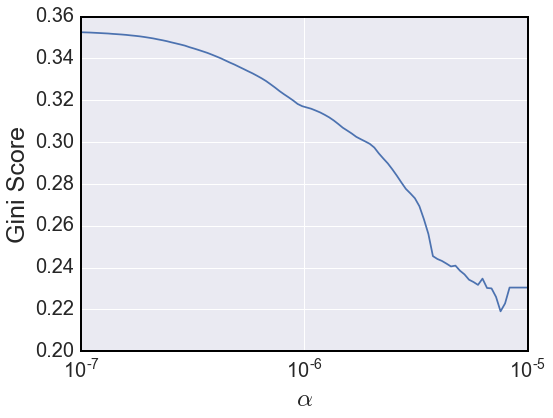

In [238]:
## plot gini vs alpha
fig=plt.figure(figsize=(8,6))
plt.semilogx(alphas_elastic,gini_score_elastic)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\alpha$',fontsize=25)
plt.ylabel('Gini Score',fontsize=25)
fig.set_dpi(1240)
fig.savefig('GINI_alpha_target.png', transparent=True, bbox_inches='tight', pad_inches=0)


###### output best solutions

###### best linear model with output=logloss
elastic = linear_model.ElasticNet(l1_ratio =0.5,normalize=True)
elastic.set_params(alpha = 1e-7)

In [233]:
elastic = linear_model.ElasticNet(l1_ratio =0.5,normalize=True)
elastic.set_params(alpha = 1e-7)
elastic.fit(X_train,y_train)
y_out = elastic.predict(X_test)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print ('gini score on test data {}'.format(gini_score))

## whole train data
elastic.fit(train_data,logloss)
# output prediction on test data
pred = elastic.predict(test_data)
## new dataframe for submission
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submis_lin_log_alphaf7.csv',index=False)

y_out = elastic.predict(train_data)
gini_score=normalized_weighted_gini(logloss,y_out,weights)
print ('gini score on whole train data {}'.format(gini_score))


gini score on test data 0.326023692376
gini score on whole train data 0.29631113805


###### best linear model with output=target
elastic = linear_model.ElasticNet(l1_ratio =0.5,normalize=True)
elastic.set_params(alpha = 1e-7)

In [240]:
elastic = linear_model.ElasticNet(l1_ratio =0.5,normalize=True)
elastic.set_params(alpha = 1e-7)
elastic.fit(X_train,y_train)
y_out = elastic.predict(X_test)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print ('gini score on test data {}'.format(gini_score))

## whole train data
elastic.fit(train_data,target)
# output prediction on test data
pred = elastic.predict(test_data)
## new dataframe for submission
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submis_lin_target_alphaf7.csv',index=False)

y_out = elastic.predict(train_data)
gini_score=normalized_weighted_gini(target,y_out,weights)
print ('gini score on whole train data {}'.format(gini_score))


gini score on test data 0.35249051435
gini score on whole train data 0.356134081943


# GradientBoostingRegressor

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [23]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05)
gbr.fit(X_train, y_train)
print ('traning doen')

KeyboardInterrupt: 

In [ ]:
y_out = gbr.predict(X_test)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print gini_score
#0.306

In [320]:
#param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
param_test3 = {'max_depth':range(1,4)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, \
                       n_estimators=50,max_depth=4,max_features='sqrt', subsample=1, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


KeyboardInterrupt: 

###### output for best solution

In [58]:
gbr_best = GradientBoostingRegressor(n_estimators=120, learning_rate=0.05,max_depth=3)
#gbr.fit(X_train,y_train)
# y_out = gbr_best.predict(X_test)
# gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
# print ('gini score on test data {}'.format(gini_score))

## whole train data
gbr_best.fit(train_data,target)
# output prediction on test data
pred = gbr_best.predict(test_data)
## new dataframe for submission
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submis_gbr_target_dep3_n120.csv',index=False)

y_out = gbr_best.predict(train_data)
gini_score=normalized_weighted_gini(target,y_out,weights)
print ('gini score on whole train data {}'.format(gini_score))
print ('done')

gini score on whole train data 0.500234892589
done


Populating the interactive namespace from numpy and matplotlib


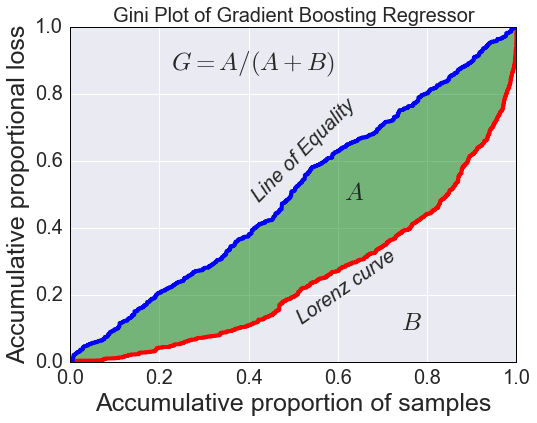

In [61]:
%pylab inline
fig = plt.figure()
# unit_weight=[1 for x in weights]
# perf=0
# lorentz0=weighted_lorentz_line(target,y_out,weights,perf)
# perf=1
# lorentzp=weighted_lorentz_line(target,target,weights,perf)
plt.plot(lorentz0.random,lorentz0.lorentz,linewidth=4,color='red')
plt.plot(lorentzp.random,lorentzp.lorentz,linewidth=4,color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(8,6) 
plt.xlabel('Accumulative proportion of samples',fontsize=25)
plt.ylabel('Accumulative proportional loss',fontsize=25)
plt.xlim([0,1])
xx=np.concatenate([lorentz0.random, lorentzp.random[::-1]])
yy=np.concatenate([lorentz0.lorentz,lorentzp.lorentz[::-1]])
plt.fill(xx, yy, color='green', alpha = 0.5)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
plt.axis('on')
fig.text(0.3, 0.8, r'$G=A/(A+B)$', fontsize=25)
fig.text(0.6, 0.5, r'$A$', fontsize=25)
fig.text(0.7, 0.2, r'$B$', fontsize=25)
plt.text(0.5,0.3,'Lorenz curve', style='italic',fontsize=20,rotation=35)
plt.text(0.4,0.75,'Line of Equality', style='italic',fontsize=20,rotation=45)
plt.title('Gini Plot of Gradient Boosting Regressor',fontsize=20)
fig.set_dpi(1240)
fig.savefig('GINI_gbr2.png', transparent=True, bbox_inches='tight', pad_inches=0)


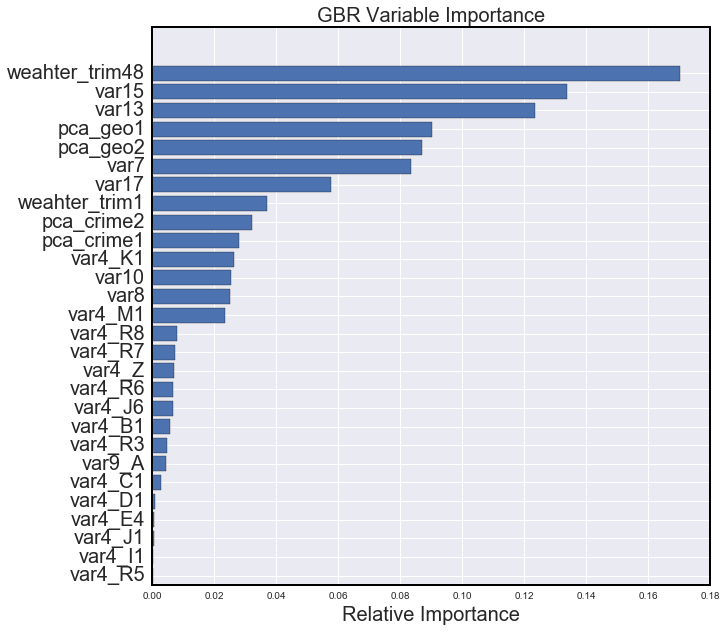

In [315]:
feature_importance = gbr.feature_importances_
num=len(gbr_best.feature_importances_)
num_plot=15
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[30:num]  ##increase order
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[[sorted_idx]])
plt.xlabel('Relative Importance',fontsize=20)
plt.yticks(fontsize=20)
plt.title('GBR Variable Importance',fontsize=20)
plt.show()

fig.set_dpi(1240)
fig.savefig('feature_importance_GBR.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [305]:
sorted_idx[0:num_plot]

array([28, 24, 25, 26, 27, 56, 29, 30, 33, 34, 35, 36, 42, 44, 45], dtype=int64)

# Gradient Boosting

In [349]:
from sklearn.ensemble import GradientBoostingClassifier

#evaluate_model(gbt)
gbm = GradientBoostingClassifier(max_features=10,n_estimators=100, 
                                 learning_rate=0.1, random_state= 2015)
gbm.fit(X_train, y_label_train)
print ('training done')

training done


In [358]:
y_out = gbm.predict_proba(X_test)[:,1]
gini_score=normalized_weighted_gini(y_label_test,y_out,weight_sub_test)
print gini_score

0.319984153474


(array([  1.12341000e+05,   5.30000000e+02,   6.20000000e+01,
          1.50000000e+01,   1.60000000e+01,   7.00000000e+00,
          8.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

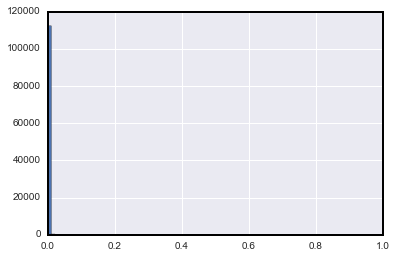

In [361]:
plt.hist(y_out,bins=100)

###### output file

In [356]:
gbc_best =  GradientBoostingClassifier(max_features=10,n_estimators=120, 
                                learning_rate=0.05, random_state= 2015)
#gbc.fit(X_train,y_train)
# y_out = gbr_best.predict(X_test)
# gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
# print ('gini score on test data {}'.format(gini_score))

## whole train data
gbc_best.fit(train_data,labels)
# output prediction on test data
pred = gbc_best.predict_proba(test_data)[:,1]
## new dataframe for submission
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submis_gbc_r005n120_maxf10.csv',index=False)

y_out = gbc_best.predict_proba(train_data)[:,1]

gini_score=normalized_weighted_gini(labels,y_out,weights)
print ('gini score on whole train data {}'.format(gini_score))
print ('done')

gini score on whole train data 0.353072141745
done


# RandomForest

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=7, )
rf.fit(xtrain_data,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
y_out=rf.predict_proba(xtrain_data)

## XGBOOST

In [318]:
folds = 5
param = {}
param['objective'] ='reg:logistic'  # 'reg:logistic' # 'binary:logitraw' 
param['silent'] = 1
param['nthread'] = 1
param['eval_metric'] = 'auc' #'rmse'
param['bst:max_depth'] = 6
param['min_child_weight']=1
param['gamma']=0
param['subsample']=1    # = c(0.5, 0.75, 1),
param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
param['learning_rate']=0.1
weights=np.asarray(weight_train)
num_round = 100 # Number of boosted trees
#estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)

In [362]:
    param['objective'] ='binary:logitraw'  
    param['max_depth'] = 3
    param['min_child_weight']=1
    param['gamma']=0
    param['subsample']=1    # = c(0.5, 0.75, 1),
    param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
    param['learning_rate']=0.1
    num_round=70

In [79]:
params = {"objective": "reg:linear", "booster":"gblinear"}
# gbm.get_dump()


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators=10)
evaluate_model(gbt)

ValueError: Unknown label type: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

##### grid scan

In [324]:
    f=open("summary_bst_scan.txt","a")
    f.write('tuning parameters=')
    f.write('\n')
    for key, values in param.items():
        f.write('param {}={}'.format(key,values))
        f.write('\n')
    f.write('nfolds=%f' %(folds))
    f.write('\n')
    f.write('num_round=%f' %(num_round))
    f.write('\n')
    f.close()
    max_depth_values=[5,6]
    min_child_weight_values=[1,2,3,4,5]
    max_depth_values=[3]
    min_child_weight_values=[2]
    
    for x in max_depth_values:
        for y in min_child_weight_values:
            f=open("summary_bst_scan.txt","a")
            f.write('\n')
            f.write('-------------')
            f.write('\n')
            param['max_depth']=x
            param['min_child_weight']=y
            f.write('param {}={}'.format('max_depth',x))
            f.write('\n')
            f.write('param {}={}'.format('mini_child_weight',y))
            f.write('\n')
            f.write('--------------')
            f.write('\n')
            f.close()
#     gamma_vlaues=[10,100]
#     for x in gamma_vlaues:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['gamma']=x
#             f.write('param {}={}'.format('gamma',x))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     subsample_values=[0.6,0.8,0.9,1]
#     colsample_bytree_values=[0.6,0.8,0.9,1]
# #     subsample_values=[1]
# #     colsample_bytree_values=[0.5,0.7]
#     for x in subsample_values:
#         for y in colsample_bytree_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['subsample']=x
#             param['colsample_bytree']=y
#             f.write('param {}={}'.format('subsample',x))
#             f.write('\n')
#             f.write('param {}={}'.format('colsample_bytree',y))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     num_round_values =[150,180,200,250]
#     num_round_values =[100,120,130,140]
#     num_round_values =[60,70,80,90]
#     for x in num_round_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             num_round =x
#             f.write('num_round={}'.format(x))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()

            estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)
    

gini_score=0.327981685394
gini_score=0.227745492294
gini_score=0.360490837748
gini_score=0.252852996267
gini_score=0.295344383439
------------------------------------------------------
mean Gimi =0.292883079028 with std=0.0482785500169
Thresh = 0.0018
Accuracy = 0.9956: Precision = 0.0086, FP = 0.9914
Thresh = 0.0019
Accuracy = 0.9955: Precision = 0.0083, FP = 0.9917
Thresh = 0.0020
Accuracy = 0.9955: Precision = 0.0080, FP = 0.9920
Thresh = 0.0020
Accuracy = 0.9954: Precision = 0.0077, FP = 0.9923
Thresh = 0.0021
Accuracy = 0.9953: Precision = 0.0074, FP = 0.9926
Thresh = 0.0022
Accuracy = 0.9952: Precision = 0.0081, FP = 0.9919
Thresh = 0.0023
Accuracy = 0.9952: Precision = 0.0078, FP = 0.9922
Thresh = 0.0023
Accuracy = 0.9951: Precision = 0.0076, FP = 0.9924
Thresh = 0.0024
Accuracy = 0.9950: Precision = 0.0073, FP = 0.9927
Thresh = 0.0025
Accuracy = 0.9949: Precision = 0.0071, FP = 0.9929
